In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 999
ML_data = pd.read_csv('ML_data.csv')

In [2]:
df = ML_data[['METHOD_MIC','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth']]

# creates features numpy array
features = df[df.columns[2:]].to_numpy()

#creates resistance label column
label = df['MUT_RESISTANCE'].to_numpy()

In [68]:
#no preprocessing - therefore, do not see why I would need a pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

forest = RandomForestClassifier(n_jobs=-1, random_state=0)

param_grid = {'n_estimators':[10,20,30,40,50,60,100],
              'max_depth':[1,2,4,6,8,10]}

X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    random_state=0)

In [69]:
# creates features and label dfs from unique mutations
def remove_duplicate_mutations(X_dataset, y_dataset):

    #converts long X_train and y_train to pd df to join
    X_train_df = pd.DataFrame(X_dataset)
    X_train_df.rename(columns = {0:'MUTATION'}, inplace = True)
    y_train_df = pd.DataFrame(y_dataset)
    y_train_df.rename(columns = {0:'MUT_RESISTANCE'}, inplace = True)

    CV_train = X_train_df.join(y_train_df,  how = 'inner')

    #removes duplicates and mutation column
    CV_train_unique = CV_train.drop_duplicates(subset='MUTATION', keep = 'first')
    CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

    #seperates into unique features and label numpy arrays
    features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
    label_unique = CV_train_unique['MUT_RESISTANCE']

    X_no_duplicates = (features_unique)
    y_no_duplicates = (label_unique)
    
    return (X_no_duplicates, y_no_duplicates)

In [70]:
X_train_nodup, y_train_nodup = remove_duplicate_mutations(X_train, y_train)
X_test_nodup, y_test_nodup = remove_duplicate_mutations(X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [71]:
#split data into training and test sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_nodup, y_train_nodup,
                                                    random_state=0)

In [72]:
#grid search with shuffled kfold validation
KFold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=KFold_shuffle)
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold_shuffle.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=2, n_estimators=40, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.6607989464442493
grid_kfold_shuffle: test set average accuracy:  0.6754385964912281 



In [73]:
from matplotlib import pyplot as plt
import numpy as np

#define and fit forests with best performing parameters, or default parameters
forest_best_params = RandomForestClassifier(max_depth=2, n_estimators=40, n_jobs=-1, random_state=0)
forest_no_params = RandomForestClassifier(random_state=0)
forest_best_params.fit(X_train_cv, y_train_cv)    
forest_no_params.fit(X_train_cv, y_train_cv)

#plot charts
def plot_feature_importances(model):
    n_features = features[:,1:].shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df.columns[3:])
    plt.xlabel('feature importance')
    plt.ylabel('feature')
    plt.ylim(-1, n_features)
    plt.title('feautre importance plot')

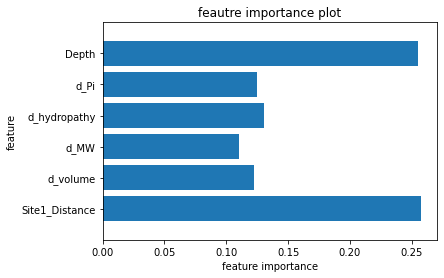

In [74]:
plot_feature_importances(forest_no_params)

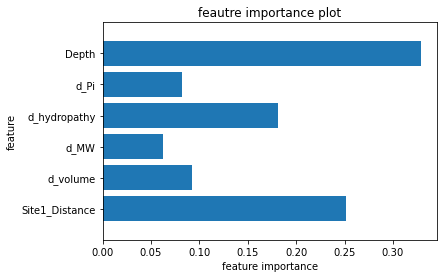

In [75]:
plot_feature_importances(forest_best_params)

In [76]:
#grid search with shuffled kfold validation
#use predict_proba function to calculate average_precision
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=kfold_shuffle, scoring='average_precision')
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set average precision: ', 
       average_precision_score(y_test_cv, grid_kfold_shuffle.predict_proba(X_test_cv)[:,1]), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=8, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.7197178401085547
grid_kfold_shuffle test set average precision:  0.7170235413587019 



In [77]:
#grid search with shuffled kfold validation
#use predict_prob a function ot calculate ROC AUC

kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=kfold_shuffle, scoring='roc_auc')
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set AUC: ', 
       roc_auc_score(y_test_cv, grid_kfold_shuffle.predict_proba(X_test_cv)[:,1]), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=8, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.7166932881036001
grid_kfold_shuffle test set AUC:  0.7626231527093597 



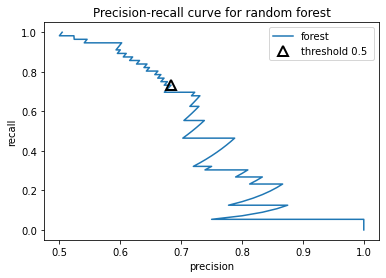

In [78]:
#precision recall curve for best average precision estimator
#max_depth=8, n_estimators=40

from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt

forest = RandomForestClassifier(max_depth=8, n_estimators=40, random_state=0)
forest.fit(X_train_cv, y_train_cv)

precision, recall, thresholds = precision_recall_curve(y_test_cv, forest.predict_proba(X_test_cv)[:, 1])

plt.plot(precision, recall, label='forest')
close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(precision[close_default], recall[close_default], '^', c='k', 
          markersize=10, label='threshold 0.5 ', fillstyle='none', mew=2)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Precision-recall curve for random forest')
plt.legend(loc='best')

Text(0.5, 1.0, 'ROC curve for random forest')

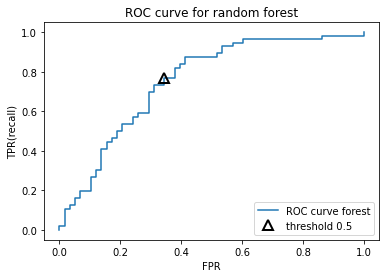

In [79]:
# parameters for best AUC: 
from sklearn.metrics import roc_curve

forest = RandomForestClassifier(max_depth=8, n_estimators=40, random_state=0)
forest.fit(X_train_cv, y_train_cv)

fpr, tpr, thresholds = roc_curve(y_test_cv, forest.predict_proba(X_test_cv)[:, 1])

plt.plot(fpr, tpr, label='ROC curve forest')
plt.xlabel('FPR')
plt.ylabel('TPR(recall)')
close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[close_default], tpr[close_default], '^', markersize=10, label='threshold 0.5', 
         fillstyle='none', c='k', mew=2)
plt.legend(loc=4)
plt.title('ROC curve for random forest')

In [80]:
#confusion matrix (max_depth=4, n_estimators=40)
#best parameters for average precision

from sklearn.metrics import confusion_matrix

forest = RandomForestClassifier(max_depth=8, n_estimators=40, random_state=0)
forest.fit(X_train_cv, y_train_cv)
predict = forest.predict(X_test_nodup).astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test_nodup, predict)

#calculate precision, sensitivity, specficity, FPR, errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.8211382113821138
Sensitivity:  0.8782608695652174
Specificity:  0.7755102040816326
FPR : 0.22448979591836737
very major error : 22.448979591836736
major error:  12.173913043478262

 confusion matrix: 
 [[ 76  22]
 [ 14 101]]


{0: 90, 1: 123}


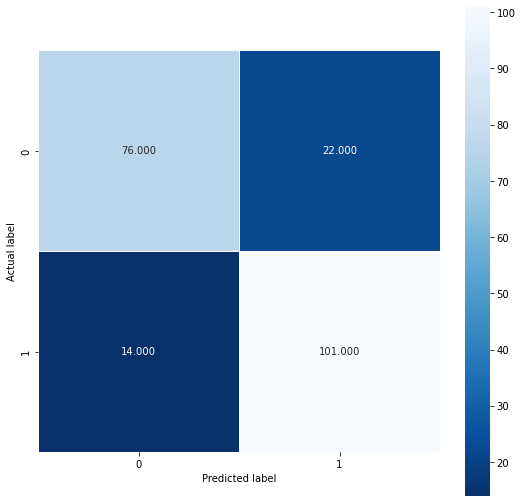

In [86]:
from sklearn import metrics
import seaborn as sns
unique, counts = np.unique(predict, return_counts=True)
print(dict(zip(unique, counts)))

cm = metrics.confusion_matrix(y_test_nodup, predict)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [88]:
forest = RandomForestClassifier(max_depth=8, n_estimators=40, random_state=0)
forest.fit(X_train_cv, y_train_cv)
predicted_proba = forest.predict_proba(X_test_nodup)
predict = (predicted_proba[:,1] >= 0.76).astype('int')

#generate confusion matrix
confusion = confusion_matrix(y_test_nodup, predict)
confusion
#significantly reduces falsely labelled susceptible samples - we need the other way around

array([[94,  4],
       [69, 46]], dtype=int64)

In [101]:
forest = RandomForestClassifier(max_depth=8, n_estimators=40, random_state=0)
forest.fit(X_train_cv, y_train_cv)
predicted_proba = forest.predict_proba(X_test_nodup)
predict = (predicted_proba[:,0] >= 0.76).astype('int')

#generate confusion matrix
confusion = confusion_matrix(y_test_nodup, predict)
confusion
#has much worse outcome the other way around

array([[ 63,  35],
       [115,   0]], dtype=int64)

Indirect binary classification via multiclass MIC classification

In [102]:
MIC_ML_data = ML_data.dropna(subset = ['METHOD_MIC'])

In [104]:
# need code to clean up values > 1.6 - need to see if RF can use continuous data

MIC_strings = []

for i in MIC_ML_data['METHOD_MIC']:
    if i == '3.2':
        MIC_strings.append('>1.6')
    elif i == '6.4':
        MIC_strings.append('>1.6')
    elif i == '12.8':
        MIC_strings.append('>1.6')
    elif i == '>12.8':
        MIC_strings.append('>1.6')
    else:
        MIC_strings.append(i)
        
MIC_ML_data['MIC_values'] = MIC_strings

C:\Users\user\AppData\Local\Temp/ipykernel_46984/380884722.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MIC_ML_data['MIC_values'] = MIC_strings


In [105]:
MIC_df = MIC_ML_data[['MIC_values','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth']]

# creates features numpy array
MIC_features = MIC_df[MIC_df.columns[2:]].to_numpy()

#creates resistance label column
MIC_label = MIC_df['MIC_values'].to_numpy()

In [106]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(MIC_features, MIC_label,
                                                    random_state=0)

In [107]:
# creates features and label dfs from unique mutations
def remove_duplicate_mutations(X_dataset, y_dataset):

    #converts long X_train and y_train to pd df to join
    X_train_df = pd.DataFrame(X_dataset)
    X_train_df.rename(columns = {0:'MUTATION'}, inplace = True)
    y_train_df = pd.DataFrame(y_dataset)
    y_train_df.rename(columns = {0:'MIC_VALUES'}, inplace = True)

    CV_train = X_train_df.join(y_train_df,  how = 'inner')

    #removes duplicates and mutation column
    CV_train_unique = CV_train.drop_duplicates(subset='MUTATION', keep = 'first')
    CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

    #seperates into unique features and label numpy arrays
    features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
    label_unique = CV_train_unique['MIC_VALUES']

    X_no_duplicates = (features_unique)
    y_no_duplicates = (label_unique)
    
    return (X_no_duplicates, y_no_duplicates)

In [108]:
X_train_nodup, y_train_nodup = remove_duplicate_mutations(X_train, y_train)
X_test_nodup, y_test_nodup = remove_duplicate_mutations(X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [109]:
#split data into training and test sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_nodup, y_train_nodup,
                                                    random_state=0)

In [110]:
#no preprocessing - therefore, no pipeline
#build classifier and parameter grid

forest = RandomForestClassifier(n_jobs=-1, random_state=0)
param_grid = {'n_estimators':[10,20,30,40,50,60, 100],
              'max_depth':[2,4,6,8,10,12,14,16]}

In [111]:
#Grid search with kfold cross validation (best cv for logreg multiclass classifcation)

KFold = KFold(n_splits=5)
grid_kfold = GridSearchCV(forest, param_grid, cv=KFold, n_jobs=-1)
grid_kfold.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=2, n_estimators=50, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.27218390804597703
grid_kfold_shuffle: test set average accuracy:  0.16 



In [112]:
#define and fit forests with best performing parameters, or default parameters
forest_best_params = RandomForestClassifier(max_depth=2, n_estimators=50, n_jobs=-1, random_state=0)
forest_no_params = RandomForestClassifier(random_state=0)
forest_best_params.fit(X_train_cv, y_train_cv)    
forest_no_params.fit(X_train_cv, y_train_cv)

#plot charts
def plot_feature_importances(model):
    n_features = features[:,1:].shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df.columns[3:])
    plt.xlabel('feature importance')
    plt.ylabel('feature')
    plt.ylim(-1, n_features)
    plt.title('feautre importance plot')

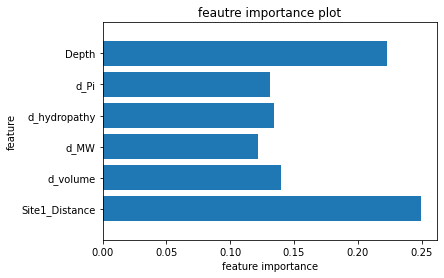

In [113]:
plot_feature_importances(forest_no_params)

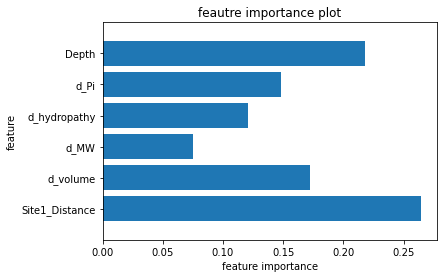

In [114]:
plot_feature_importances(forest_best_params)

In [116]:
#copy and fit classifier with best parameters from previous section
forest = forest_best_params
forest.fit(X_train_cv, y_train_cv)                 
                 
predict = forest.predict(X_test_nodup)
#generate confusion matrix
confusion = confusion_matrix(y_test_nodup, predict)

print ('\n confusion matrix: \n', confusion)


 confusion matrix: 
 [[ 1  0  0  0  0  0  7  1]
 [ 2  0  0  0  0  0  3  7]
 [ 3  0  0  0  0  0  3  5]
 [ 0  0  0  0  0  0  4  7]
 [ 1  0  0  0  0  0  1  3]
 [ 1  0  0  0  0  0  0  4]
 [ 1  0  0  0  0  0  6  2]
 [ 0  0  0  0  0  0  2 11]]


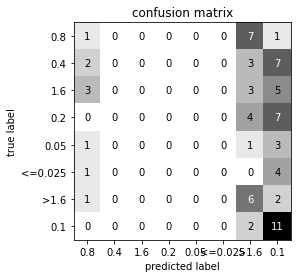

In [119]:
#generate heatmap of confusion matrix for visualisation
import mglearn

target_names = MIC_ML_data['MIC_values'].unique().tolist()
scores_image = mglearn.tools.heatmap(confusion, xlabel='predicted label',
                                     ylabel='true label', xticklabels=target_names,
                                     yticklabels=target_names, cmap=plt.cm.gray_r, fmt='%d')
plt.title('confusion matrix')
plt.gca().invert_yaxis()

In [120]:
#generate classification report
from sklearn.metrics import classification_report

print (classification_report(y_test_nodup, predict, zero_division=True))

              precision    recall  f1-score   support

        0.05       0.11      0.11      0.11         9
         0.1       1.00      0.00      0.00        12
         0.2       1.00      0.00      0.00        11
         0.4       1.00      0.00      0.00        11
         0.8       1.00      0.00      0.00         5
         1.6       1.00      0.00      0.00         5
     <=0.025       0.23      0.67      0.34         9
        >1.6       0.28      0.85      0.42        13

    accuracy                           0.24        75
   macro avg       0.70      0.20      0.11        75
weighted avg       0.68      0.24      0.13        75



In [121]:
# will categorise multiclass data into 2 groups
def MIC_to_binary(data):
    RS_dict = {1:['0.2','0.4','0.8','1.6','>1.6'],
           0:['<=0.025','0.05','0.1']}
    binary_list = []
    for i in data:
        for k,v in RS_dict.items():
            for j in v:
                if i == j:
                    binary_list.append(k)

    binary_array = np.array(binary_list)
    return binary_array

In [123]:
#generate confusion matrix
confusion = confusion_matrix(MIC_to_binary(y_test_nodup), MIC_to_binary(predict))

#calculate precision, sensitivity, specificty, FPR, and errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.75
Sensitivity:  0.6666666666666666
Specificity:  0.6666666666666666
FPR : 0.33333333333333337
very major error : inf
major error:  inf

 confusion matrix: 
 [[20 10]
 [15 30]]


C:\Users\user\AppData\Local\Temp/ipykernel_46984/4269136536.py:9: RuntimeWarning: divide by zero encountered in longlong_scalars
  very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
C:\Users\user\AppData\Local\Temp/ipykernel_46984/4269136536.py:10: RuntimeWarning: divide by zero encountered in longlong_scalars
  major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100


In [124]:
print (classification_report(MIC_to_binary(y_test_nodup), MIC_to_binary(predict)))

              precision    recall  f1-score   support

           0       0.57      0.67      0.62        30
           1       0.75      0.67      0.71        45

    accuracy                           0.67        75
   macro avg       0.66      0.67      0.66        75
weighted avg       0.68      0.67      0.67        75

